## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
df.query('converted == 1').nunique()['user_id']/df['user_id'].nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
df.query('group == "treatment" & landing_page != "new_page"').count()['user_id'] + df.query('group != "treatment" & landing_page == "new_page"').count()['user_id']

3893

f. Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**No.**

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = df.query('(group == "control" & landing_page == "old_page") | (group == "treatment" & landing_page == "new_page")')

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.duplicated(['user_id'])]['user_id']


2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.drop_duplicates(subset='user_id')

Checking that we removed the duplicated user_id successfully.

In [15]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.query('converted == 1').nunique()['user_id']/df2['user_id'].nunique()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2.query('converted == 1 & group == "control"').nunique()['user_id']/df2.query('group == "control"').nunique()['user_id']

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2.query('converted == 1 & group == "treatment"').nunique()['user_id']/df2.query('group == "treatment"').nunique()['user_id']

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
df2.query('landing_page == "new_page"').nunique()['user_id']/df2['user_id'].nunique()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Control group conversion rate is 12,04% while treatment group conversion rate is 11,89%. The probability of landing in the new page is near a fair coin flip. Nevertheless, we cannot assume the new treatment page leads to less conversions since there are some biases in regards of adapting to the new page style from the user's perspective.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

$$ H_0: P_{new} - P_{old} \leq 0  $$ 
$$ H_1: P_{new} - P_{old} > 0  $$ 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2.query('converted == 1')['user_id'].nunique()/df2['user_id'].nunique()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2.query('converted == 1')['user_id'].nunique()/df2['user_id'].nunique()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([0,1],n_new, p=(p_new,1-p_new))
new_page_converted

array([1, 1, 0, ..., 1, 1, 1])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice([0,1],n_old, p=(p_old,1-p_old))
old_page_converted

array([1, 1, 0, ..., 1, 0, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
new_page_converted.mean() - old_page_converted.mean()

0.00088318520139807344

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0,1],n_new, p=(p_new,1-p_new)).mean()
    old_page_converted = np.random.choice([0,1],n_old, p=(p_old,1-p_old)).mean()
    p_diffs.append(new_page_converted - old_page_converted)

In [28]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

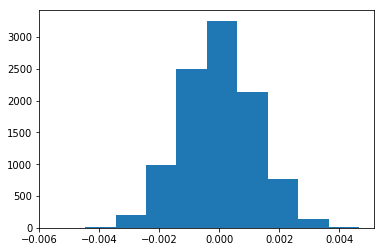

In [29]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

To achieve that calculation and answer that question we have to calculate additional variables.

In [30]:
old_conversions = df2.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique()
new_conversions = df2.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique()

In [31]:
old_conversions_ratio = old_conversions/n_old
new_conversions_ratio = new_conversions/n_new

We calculate the observed difference.

In [32]:
obs_diff = new_conversions_ratio - old_conversions_ratio
obs_diff

-0.0015782389853555567

In [33]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

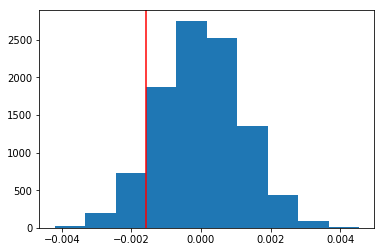

In [34]:
plt.hist(null_vals)
plt.axvline(x=obs_diff,color ='red');

Proportion of the **p_diffs** are greater than the actual difference observed (**obs_diff**).

In [35]:
(null_vals > obs_diff).mean()

0.90469999999999995

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**When p is close to 1 we should stay with $H_0$ (the null hypothesis). So, in this case we fail to reject the null hypothesis (assuming there is a type I error rate of 5%). The value is called p-value, which is the probability of observing the statistic from $H_O$ (or even a more extreme statistic). So, in this case there is no large difference between new and old pages in terms of conversion.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [37]:
import statsmodels.api as sm

convert_old = df2.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique()
convert_new = df2.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique()
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [38]:
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new, convert_old]), np.array([n_new, n_old]), alternative = 'larger')

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [39]:
print('z-score: ', z_score)
print('p_value: ', p_value)

z-score:  -1.31092419842
p_value:  0.905058312759


**The p-value calculated here is similar than the one we calculated in part j. Z-score, which is calculated with this formula: $Z= \frac{X - \mu}{\sigma}$, tells us how many standard deviations we are from the mean. A negative z-score reveals the raw score is below the mean average**

To tell de significance of the z-score we can do the following calculation:

In [40]:
from scipy.stats import norm

sig_z = norm.cdf(z_score)
sig_z

0.094941687240975514

To calculate the critical value at a 95% confidence interval:

In [41]:
crit_z = norm.ppf(1-(0.05/2))
crit_z

1.959963984540054

**Since sig_z < crit_z we will able to say that we fail to reject $H_0$. There is no significant statistical evidence to conclude $H_1$ (the alternate hypothesis). So we are able to say:
$$ P_{new} - P_{old} \ngtr 0  $$**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since our explanatory variables are continuous and our response variable is categorical we should use the logistic regression approach.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [42]:
df2['intercept'] = 1

In [43]:
df2= df2.join(pd.get_dummies(df2['landing_page']))
df2['ab_page'] = pd.get_dummies(df['group']) ['treatment']

In [44]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [45]:
#Used this code to solve the error: "module 'scipy.stats' has no attribute 'chisqprob"
from scipy import stats
stats.chisqprob = lambda chisq, df2: stats.chi2.sf(chisq, df2)

In [46]:
log_r = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = log_r.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [47]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        00:41:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value in ab_page is 0,190. Part II assumes $P_{old} \geq P_{new}$ unless $H_1$ proves to be better at a type I error rate of 5%. In this case, the explanatory variable is different.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding additional terms could lead us to multicollinearity, which is a disadvange. In that case we should consider the VIF Factor, which is: $VIF_i = \frac{1}{1-R^2_i}$. Where $R^2_i$ is the R-square for each predictor variable by the rest of the x variables. If a VIF of an explanatory variable is greater than 10 we should consider eliminating explanatory variables from the model. We could also use timestamp variable, but in that case it would be better to make a segmentation and convert the variable to categorical (with time slots).**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [48]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [49]:
df3 = df2.merge(countries, on ='user_id', how='left')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US


In [50]:
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3 = df3.drop(df3['CA'])

In [51]:
df3['US_ab_page'] = df3['US'] * df3['ab_page']
df3['UK_ab_page'] = df3['UK'] * df3['ab_page']

In [57]:
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,CA,UK,US,US_ab_page,UK_ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,0,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,0,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US,0,0,1,0,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,1,0,US,0,0,1,0,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,1,CA,1,0,0,0,0


In [53]:
df3['intercept'] = 1

In [54]:
logit3 = sm.Logit(df3['converted'], df3[['intercept','new_page','UK','US', 'US_ab_page', 'UK_ab_page']])
result = logit3.fit()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [55]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290582
Model:                          Logit   Df Residuals:                   290576
Method:                           MLE   Df Model:                            5
Date:                Sun, 21 Jun 2020   Pseudo R-squ.:               3.484e-05
Time:                        00:43:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1917
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
new_page      -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0176      0.038      0.466      0.641      -0.056       0.091
US_ab_page     0.0469      0.054      0.871      0.384      -0.059       0.152
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

Interpreting the coefficients:

In [56]:
print('For every unit decreased in new_page, conversion rate increases (caeteris paribus): ', 1/np.exp(-0.0674))
print('For every unit decreased in US, conversion rate increases (caeteris paribus): ', 1/np.exp(0.0176))
print('For every unit decreased in US_ab_page, conversion rate increases (caeteris paribus): ', 1/np.exp(0.0469))
print('For every unit decreased in UK, conversion rate increases (caeteris paribus): ', 1/np.exp(0.0118))
print('For every unit decreased in UK_ab_page, conversion rate increases (caeteris paribus): ', 1/np.exp(0.0783))

For every unit decreased in new_page, conversion rate increases (caeteris paribus):  1.06972328192
For every unit decreased in US, conversion rate increases (caeteris paribus):  0.982553975355
For every unit decreased in US_ab_page, conversion rate increases (caeteris paribus):  0.954182811101
For every unit decreased in UK, conversion rate increases (caeteris paribus):  0.988269346967
For every unit decreased in UK_ab_page, conversion rate increases (caeteris paribus):  0.924686978835


**Responding to question .g in this section, the statistical results makes us able to say that the country does have an impact on conversion rate (using CA or Canada as the baseline).** 

### Conclusions on A/B Test

A/B Test leads us to fail to reject $H_O$ (null hypothesis) since our conversion rate increases when we decrease units of new page observations. We also tested $H_0$ against $H_1$ with other models that lead us to similar results. Nevertheless, an extended experiment could lead us to reject $H_0$ and change to $H_1$ (alternate hypothesis).

End of the project.